<img src= "https://static-01.hindawi.com/styles/hindawi_wide/s3/2019-11/Cancer_Awareness-2019_blog_v1.0_noText.jpg?itok=CR034IE-" alt ="Titanic" style='width: 1080px;'>

# Breast Cancer Prediction

### Disclaimer :  

* Acccuracies and other metrics may change with random states of your splitting algorithms and models.  
* To evaluate metrics representative of your model, run your model a few times with different random states and different splitting proportion and get their mean.


To know more about the data : https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-wisconsin-data/data.csv


In [2]:
cancer = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
cancer = cancer.drop('id', axis=1)
cancer.sample(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
429,B,12.72,17.67,80.98,501.3,0.07896,0.04522,0.014020,0.01835,0.1459,...,20.96,88.87,586.8,0.10680,0.09605,0.03469,0.03612,0.2165,0.06025,NaN
350,B,11.66,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.01162,0.1671,...,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825,NaN
125,B,13.85,17.21,88.44,588.7,0.08785,0.06136,0.014200,0.01141,0.1614,...,23.58,100.30,725.9,0.11570,0.13500,0.08115,0.05104,0.2364,0.07182,NaN
463,B,11.60,18.36,73.88,412.7,0.08508,0.05855,0.033670,0.01777,0.1516,...,24.02,82.68,495.1,0.13420,0.18080,0.18600,0.08288,0.3210,0.07863,NaN
348,B,11.47,16.03,73.02,402.7,0.09076,0.05886,0.025870,0.02322,0.1634,...,20.79,79.67,475.8,0.15310,0.11200,0.09823,0.06548,0.2851,0.08763,NaN


# EDA

In [3]:
def EDA(df):
        
    print('\033[1m' + 'Shape of the data :' + '\033[0m')
    print(df.shape, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'All columns from the dataframe :' + '\033[0m')
    print(df.columns, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Datatpes and Missing values:' + '\033[0m')
    print(df.info(), 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Summary statistics for the data' + '\033[0m')
    print(df.describe(include='all'), 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Outliers in the data :' + '\033[0m')
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
    print(outliers.sum(), 
          '\n------------------------------------------------------------------------------------\n')
        
    print('\033[1m' + 'Memory used by the data :' + '\033[0m')
    print(df.memory_usage(), 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Number of duplicate values :' + '\033[0m')
    print(df.duplicated().sum())
          
EDA(cancer)

Shape of the data :
(569, 32) 
------------------------------------------------------------------------------------

All columns from the dataframe :
Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object') 
------------------------------------------------------------------------------------

Datatpes and Missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Dat

# Visualization

In [4]:
# Dropping Unnamed column
cancer = cancer.loc[:, ~cancer.columns.str.contains('^Unnamed')]

# Encoding target variable
cancer.diagnosis = cancer.diagnosis.astype('category')
cancer.diagnosis = cancer.diagnosis.cat.codes
cancer.diagnosis.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [5]:
cancer_mean = cancer.loc[:, 'radius_mean':'fractal_dimension_mean']
cancer_mean['diagnosis'] = cancer['diagnosis']

In [6]:
# Plotly's Scatterplot matrix

dimensions = []
for col in cancer_mean:
    dimensions.append(dict(label = col, values = cancer_mean[col]))
    
fig = go.Figure(data = go.Splom(
                dimensions = dimensions[:-2],
                showupperhalf=False,
                diagonal_visible=False,
                marker=dict(
                    color='rgba(135, 206, 250, 0.5)',
                    size=5,
                    line=dict(
                        color='MediumPurple',
                        width=0.5))
                ))

fig.update_layout(
    title='Pairplot for mean attributes of the dataset',
    width=1100,
    height=1500,
)

fig.show()

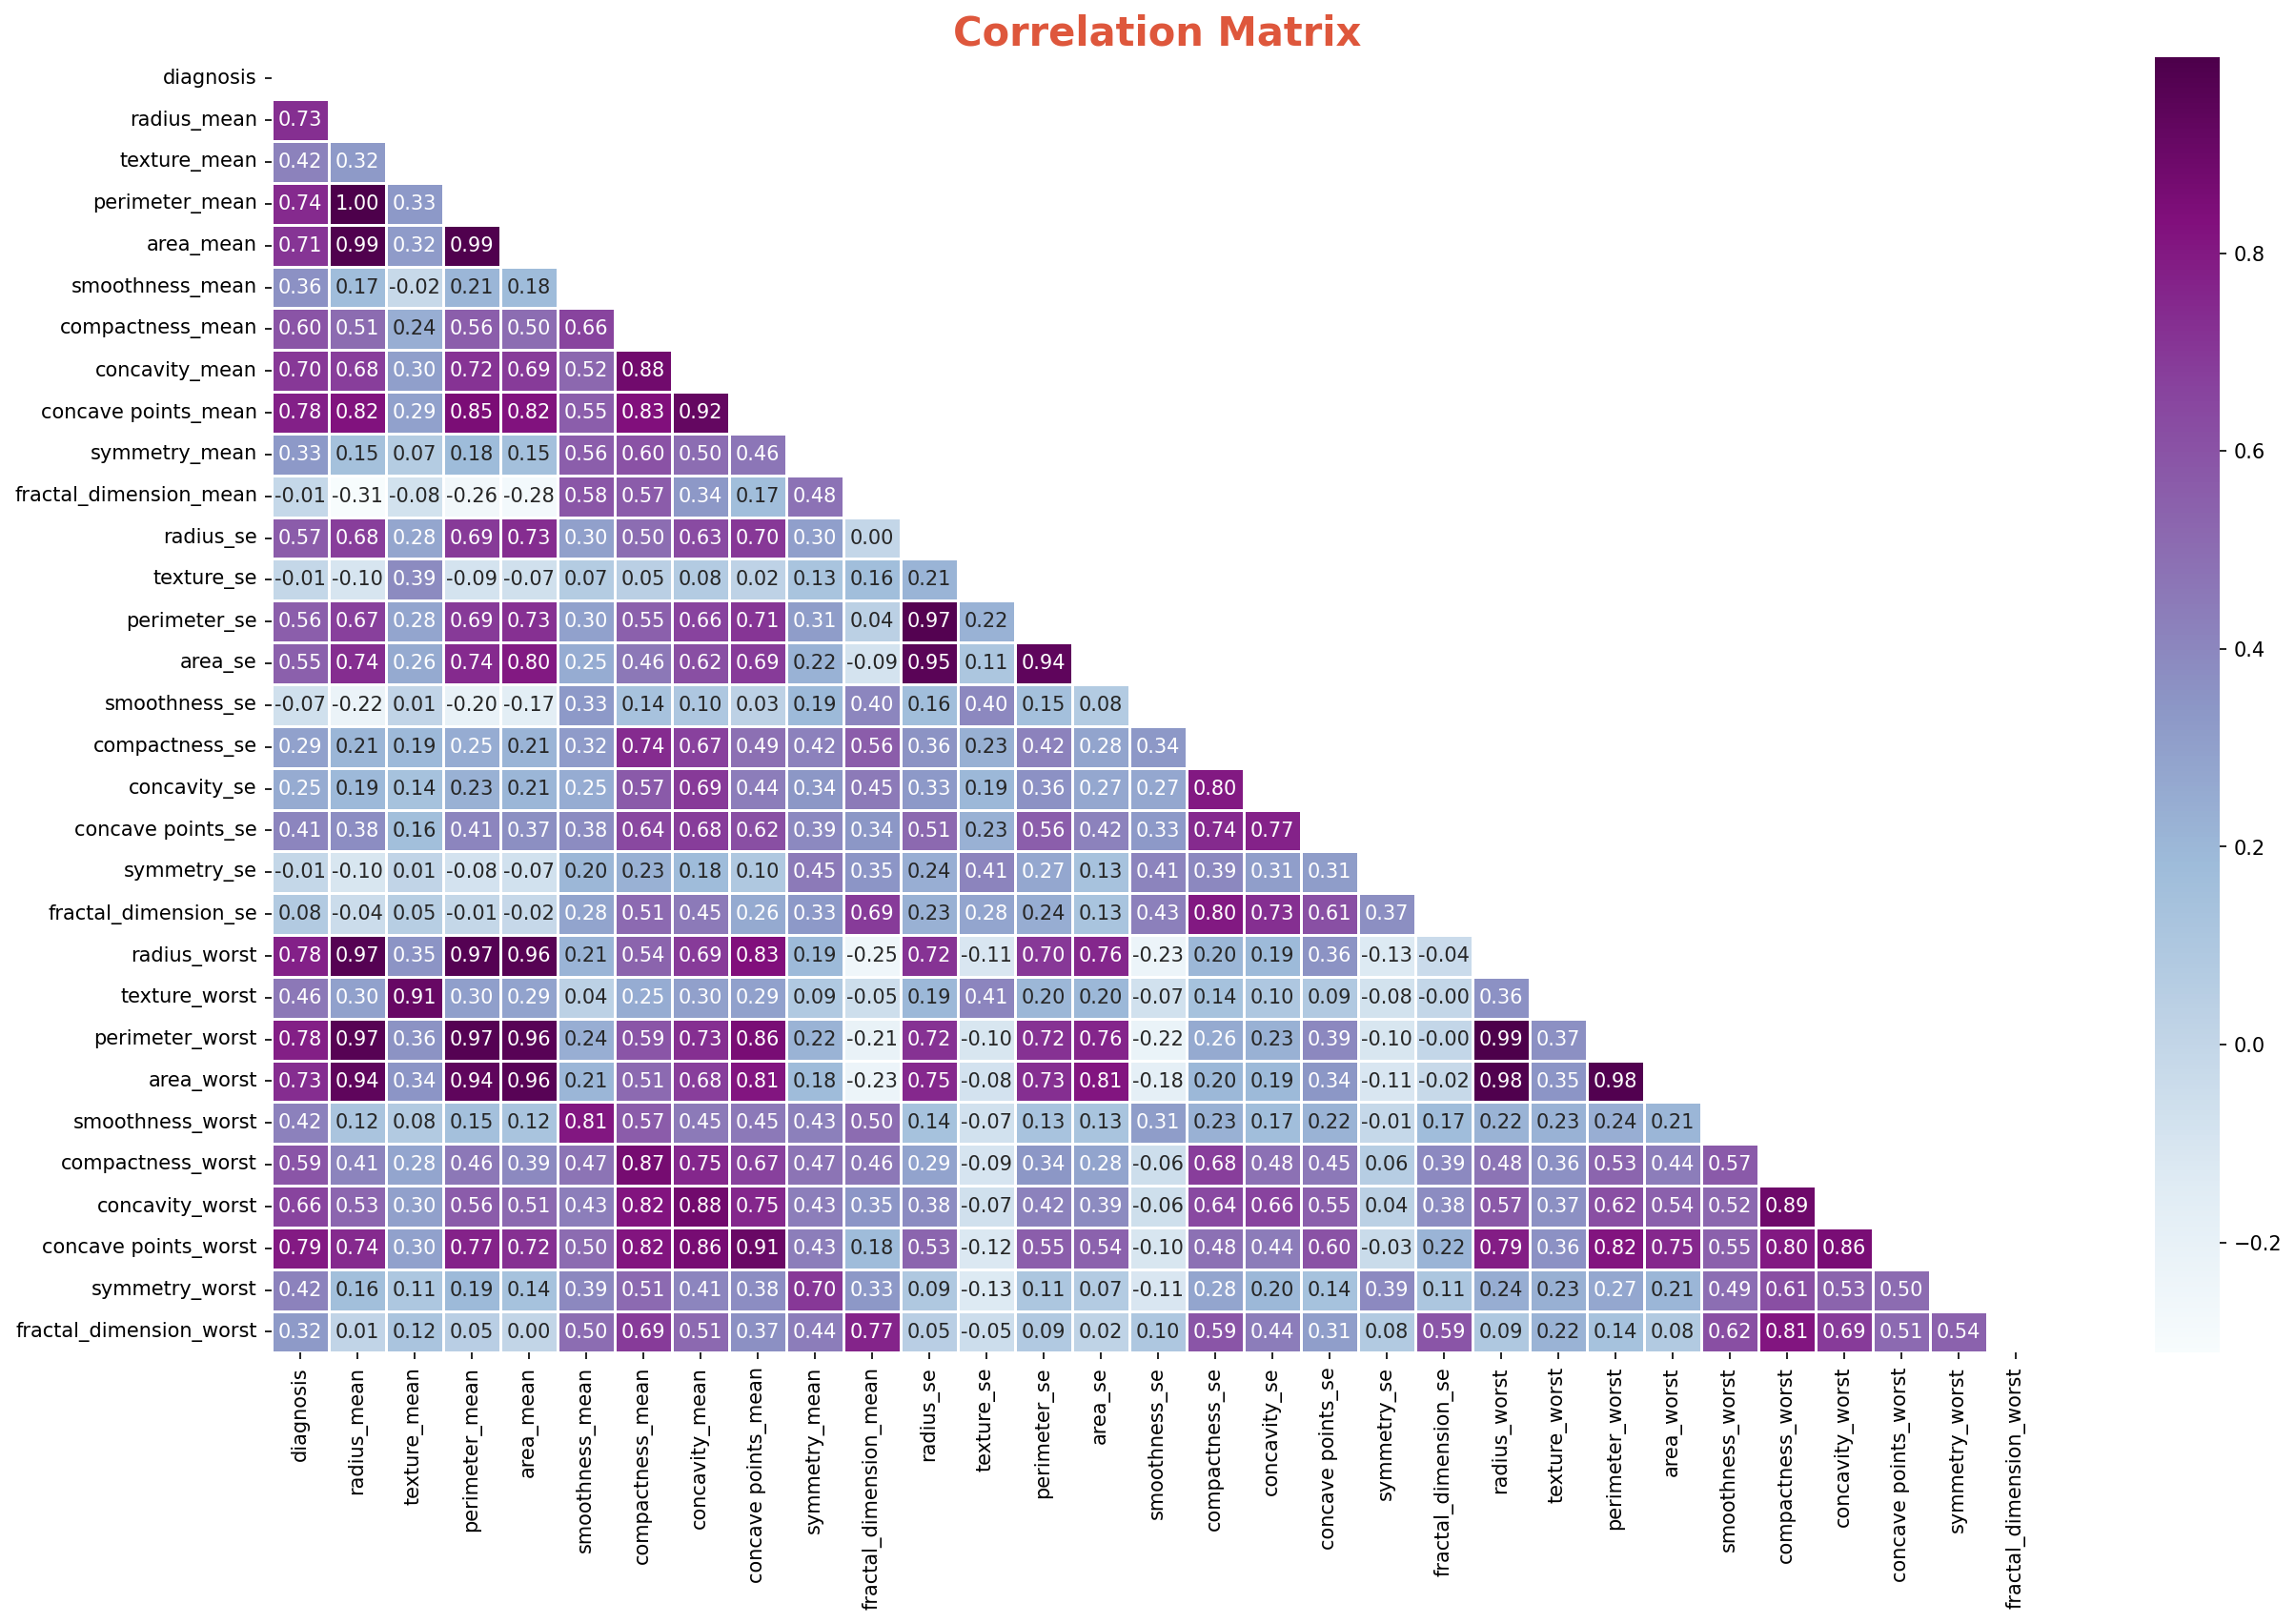

In [7]:
# Correlation matrix

plt.figure(figsize = (20, 12), dpi = 150)

corr = cancer.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr,
            mask = mask,
            cmap = 'BuPu',
            annot = True,
            linewidths = 0.5,
            fmt = ".2f")

plt.title('Correlation Matrix',
          fontsize = 20,
          weight = 'semibold',
          color = '#de573c')
plt.show()

We observe there's a strong positive correlation among a few variables.

In [8]:
def subplot_titles(cols):
    '''
    Creates titles for the subplot's subplot_titles parameter.
    '''
    titles = []
    for i in cols:
        titles.append(i+' : Distribution')
        titles.append(i+' : Violin plot')
        titles.append(i+' by Diagnosis')
    
    return titles

def subplot(cols, row = 0, col = 3):
    '''
    Takes a dataframe as an input and returns distribution plots for each variable.
    '''
    row = len(cols)
    fig = make_subplots(rows=row, cols=3, subplot_titles = subplot_titles(cols))
    
    for i in range(row):
        fig.add_trace(go.Histogram(x = cancer[ cols[i] ],
                      opacity = 0.7),
                      row=i+1, col=1)

        fig.add_trace(go.Violin(y = cancer[cols[i]],
                     box_visible=True),
                     row=i+1, col=2)

        fig.add_trace(go.Box(
                     y = cancer[ cols[i] ][cancer.diagnosis == 0],
                     marker_color = '#6ce366',
                     name = 'Benign'
                     ),row=i+1, col=3)

        fig.add_trace(go.Box(
                     y = cancer[ cols[i] ][cancer.diagnosis == 1],
                     marker_color = '#de5147',
                     name = 'Malignant'
                     ),row=i+1, col=3)
    
    for i in range(row):
        fig.update_xaxes(title_text = cols[i], row=i+1)
    
    fig.update_yaxes(title_text="Count")
    fig.update_layout(height= 450*row, width=1100,
                  title = 'Summary of mean tumor attributes (For Diagnois : Green=Benign, Red=Malignant)',
                  showlegend = False,
                  plot_bgcolor="#f7f1cb"
                  )    
    
    fig.show()
    
    

In [9]:
 x = subplot(cancer.drop('diagnosis', axis=1).columns)

# Data Preprocessing

## Dealing with outliers

In [10]:
def outlier(df):
        df_ = df.copy()
        df = df.drop('diagnosis', axis=1)


        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_limit = q1 -(1.5 * iqr) 
        upper_limit = q3 +(1.5 * iqr)


        for col in df.columns:
            for i in range(0,len(df[col])):
                if df[col][i] < lower_limit[col]:            
                    df[col][i] = lower_limit[col]

                if df[col][i] > upper_limit[col]:            
                    df[col][i] = upper_limit[col]    


        for col in df.columns:
            df_[col] = df[col]

        return(df_)

cancer = outlier(cancer)

### Separating features and target

In [11]:
X = cancer.drop('diagnosis', axis=1)
y = cancer.diagnosis

# Feature Selection using VIF

We saw in our correlation matrix, many of our predictor variables were higly correlated.  
To avoid multicollinearity, we must deal with such columns.

We can use several techniques (Chi-sq test, Random Forest Importance, Forest Feature Selection, Exhaustive Feature Selection, fisher score just to name a few)  
but here, I'll use Variance inflation factor.

In [12]:
def VIF(df):
    vif = pd.DataFrame()
    vif['Predictor'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, col) for col in range(len(df.columns))]
    return vif

vif_df = VIF(X).sort_values('VIF', ascending = False, ignore_index = True)
print(vif_df.head(8))

# Removing features with VIF > 10,000

high_vif_features = list(vif_df.Predictor.iloc[:2])
vif_features = X.drop(high_vif_features, axis=1)

                 Predictor           VIF
0              radius_mean  32981.932892
1           perimeter_mean  30694.592305
2             radius_worst   7964.577524
3          perimeter_worst   3898.538972
4                area_mean   1397.107633
5               area_worst   1219.448662
6   fractal_dimension_mean    726.110837
7  fractal_dimension_worst    599.661757


In [13]:
# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(vif_features, y, test_size = 0.2, random_state = 39)

# Logistic Regression

Best parameters :  {'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Accuracy : 99.12%
Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix : 


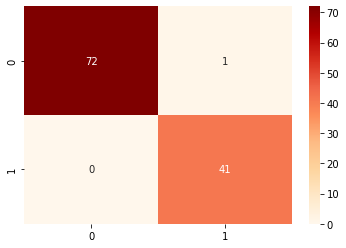

In [14]:
# Logistic regression with VIF features , BaggingClassifier and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('log_reg', LogisticRegression())]
pipeline = Pipeline(steps)

parameters = dict(log_reg__solver = ['newton-cg', 'lbfgs', 'liblinear'],
                  log_reg__penalty =  ['l2'],
                  log_reg__C = [100, 10, 1.0, 0.1, 0.01])


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  error_score = 0.0)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
log_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(log_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# KNearestNeighbor

Best parameters :  {'knn__base_estimator__metric': 'euclidean', 'knn__base_estimator__n_neighbors': 6, 'knn__base_estimator__weights': 'uniform', 'knn__bootstrap': True, 'knn__bootstrap_features': True, 'knn__n_estimators': 5}
Accuracy : 95.61%
Classification report : 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix : 


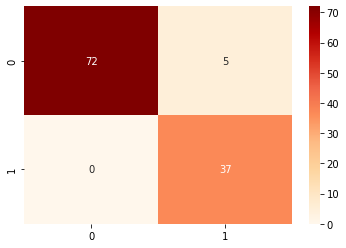

In [15]:
# KNN with VIF features and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('knn', BaggingClassifier(KNeighborsClassifier()))]
pipeline = Pipeline(steps)

parameters = dict(knn__base_estimator__metric = ['euclidean', 'manhattan', 'minkowski'],
                  knn__base_estimator__weights =  ['uniform', 'distance'],
                  knn__base_estimator__n_neighbors = range(2,15),
                  knn__bootstrap = [True, False],
                  knn__bootstrap_features = [True, False],
                  knn__n_estimators = [5])


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  )

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
knn_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(knn_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# Support Vector Classifier

Best parameters :  {'svc__C': 15, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Accuracy : 97.37%
Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix : 


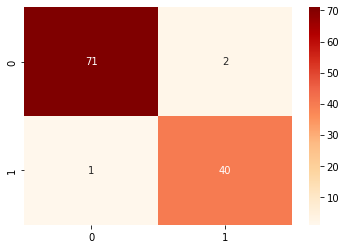

In [16]:
# SVC with VIF features and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('svc', SVC())]
pipeline = Pipeline(steps)

parameters = dict(svc__kernel = ['poly', 'rbf', 'sigmoid'],
                  svc__gamma =  [0.0001, 0.001, 0.01, 0.1],
                  svc__C = [0.01, 0.05, 0.5, 0.1, 1, 10, 15, 20])


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
svc_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(svc_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# Random Forest

Best parameters :  {'rf__max_features': 'log2', 'rf__n_estimators': 10}
Accuracy : 99.12%
Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix : 


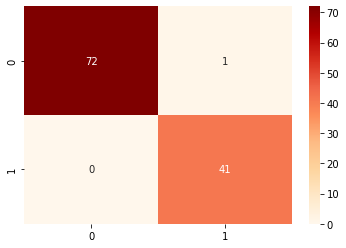

In [17]:
# Random Forest Classifier with VIF features and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('rf', RandomForestClassifier(random_state = 0))]
pipeline = Pipeline(steps)

parameters = dict(rf__n_estimators = [10,100],
                  rf__max_features = ['sqrt', 'log2'],
)


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
rf_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(rf_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# Ridge Classifier

Best parameters :  {'ridge__alpha': 0.8}
Accuracy : 95.61%
Classification report : 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix : 


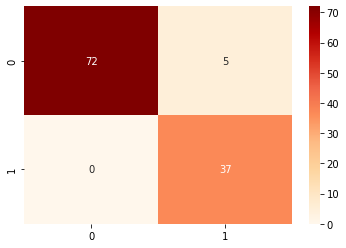

In [18]:
# Ridge Classifier with VIF features and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('ridge', RidgeClassifier())]
pipeline = Pipeline(steps)

parameters = dict(ridge__alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  error_score = 0.0)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
ridge_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(ridge_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# Gradient Boosting

Best parameters :  {'gbc__learning_rate': 1, 'gbc__loss': 'exponential', 'gbc__n_estimators': 100}
Accuracy : 99.12%
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.98      1.00      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix : 


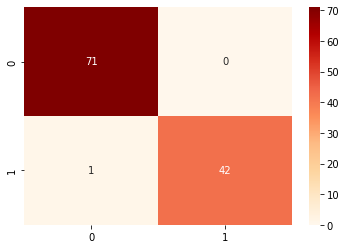

In [19]:
# Gradient Boosting Classifier  with VIF features  and hyperparameter tuning

steps = [('scaler', StandardScaler()),
         ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

parameters = dict(gbc__n_estimators = [10,100,200],
                  gbc__loss = ['deviance', 'exponential'],
                  gbc__learning_rate = [0.001, 0.1, 1, 10]
)


cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -1,
                  error_score = 0.0
                  )

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
gb_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(gb_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# XGBoost

Hypertuning parameters of XGBoost is out of scope of this notebook as it can take hours or even days to reach the optimal parameters.  
But in case you want to do so, you can try using something similar to the code below.



parameters = dict(xgb__max_depth = range(3,10,2),  
                  xgb__min_child_weight = range(1,6,2),  
                  xgb__gamma = [i/10.0 for i in range(0,5)],  
                  xgb__subsample = [i/10.0 for i in range(6,10)],  
                  xgb__colsample_bytree = [i/10.0 for i in range(6,10)],  
                  xgb__reg_alpha = [1e-5, 1e-2, 0.1, 1, 100],  
                  xgb__learning_rate = [0.001, 0.1, 1, 10])  




Best parameters :  {'gbc__learning_rate': 1, 'gbc__loss': 'exponential', 'gbc__n_estimators': 100}
Accuracy : 97.37%
Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix : 


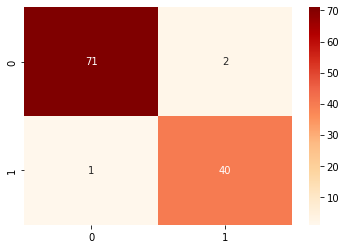

In [20]:
# Extreme gradient Boosting classifier with VIF features

xgb = XGBClassifier(max_depth = 5,
                        min_child_weight = 1,
                        gamma = 0.3,
                        subsample = 0.8,
                        colsample_bytree = 0.8,
                        learning_rate = 0.1,
                        reg_alpha=0.05,
                        disable_default_eval_metric = True)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

xgb_accuracy = accuracy_score(y_pred, y_test) * 100

print('\033[1m' +'Best parameters : '+ '\033[0m', cv.best_params_)
print('\033[1m' +'Accuracy : {:.2f}%'.format(xgb_accuracy) + '\033[0m')
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# RESULTS

In [21]:
# Accuracies of models

results = {'Model' :['Logistic Regression', 'KNN', 'SVC', 'Random Forest', 'Rigde Classifier', 'Gradient Boosting', 'XGBoost'],
           'Accuracy' : [log_accuracy, knn_accuracy, svc_accuracy, rf_accuracy, ridge_accuracy, gb_accuracy, xgb_accuracy]}

results = pd.DataFrame(results).sort_values('Accuracy', ignore_index=True, ascending=False)
results.Accuracy = results.Accuracy.round(2)
results

,Model,Accuracy
0,Logistic Regression,99.12
1,Random Forest,99.12
2,Gradient Boosting,99.12
3,SVC,97.37
4,XGBoost,97.37
5,KNN,95.61
6,Rigde Classifier,95.61


#### We see with hyperparamter tuning, three of our models got an out of sample accuracy of over 99%.

In [22]:
fig = px.line(results,
            x = results.Model,
            y = results.Accuracy,
            text=results.Accuracy,
        )
fig.update_traces(textposition = 'top right')
fig.update_layout(title = 'Model vs Accuracy',
                  plot_bgcolor = '#f9faed')

fig.show()

* Thanks for sitting through my notebook.
* Any feedback will be valuable.

# 